# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

# Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
#import tensorflow as tf
import zipfile
import cv2

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

## Object detection imports
Here are the imports from the object detection module.

In [3]:
sys.path.append("D:\\Python\\models-master\\research\\")
from object_detection.utils import ops as utils_ops

from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

In [80]:
import glob
PATH_TO_TEST_IMAGES_DIR = 'C:\\tensorflow1\\models\\research\\object_detection\\Uploads'
TEST_IMAGE_PATHS=glob.glob('C:\\tensorflow1\\models\\research\\object_detection\\Uploads\\*.*g')
IMAGE_SIZE = (12, 8)

In [4]:
# What model to download.
MODEL_NAME = 'object_detection/exp_inf_graph_350k'


# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'object_detection/training/object-detection.pbtxt'

NUM_CLASSES = 8

In [7]:
label_map = label_map_util.load_labelmap("C:\\tensorflow1\\models\\research\\object_detection\\training\\object-detection.pbtxt")

## Load a (frozen) Tensorflow model into memory.

In [6]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [8]:
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [9]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

# Detection

In [76]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

In [2]:
def crop_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image_np = load_image_into_numpy_array(image)
    image_np_expanded = np.expand_dims(image_np, axis=0)
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    original=image_np.copy()
    
    original.save("testocr.jpg")
    for i in range(0,3):
        
        image_center = (width/2, height/2)
        rotation_mat = cv2.getRotationMatrix2D(image_center, 90, 1.)
        bound_w = height
        bound_h = width
        rotation_mat[0, 2] += bound_w/2 - image_center[0]
        rotation_mat[1, 2] += bound_h/2 - image_center[1]
        rotated_mat = cv2.warpAffine(image_np, rotation_mat, (bound_w, bound_h))
        

        if (output_dict['detection_scores'][i]<0.8):
            pass
        else:
            class_name=category_index[output_dict['detection_classes'][i]]['name']
            if class_name not in foundClasses:
                foundClasses.append(class_name)
                ymin = int((output_dict['detection_boxes'][i][0]*height))
                xmin = int((output_dict['detection_boxes'][i][1]*width))
                ymax = int((output_dict['detection_boxes'][i][2]*height))
                xmax = int((output_dict['detection_boxes'][i][3]*width))
                crop=original[ymin:ymax,xmin:xmax]
                im = Image.fromarray(crop)
                im.save("testocr.jpg")
    
    return cv2.imread("testocr.jpg")    

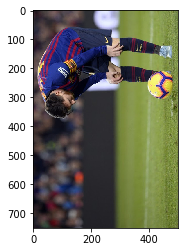

In [73]:
image = Image.open('C:\\Users\\Admin\\Desktop\\messi.jpg').convert("RGB")
image_np = load_image_into_numpy_array(image)

height, width = image_np.shape[:2] # image shape has 3 dimensions
image_center = (width/2, height/2) # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape

rotation_mat = cv2.getRotationMatrix2D(image_center, 90, 1.)



bound_w = height
bound_h = width

rotation_mat[0, 2] += bound_w/2 - image_center[0]
rotation_mat[1, 2] += bound_h/2 - image_center[1]

rotated_mat = cv2.warpAffine(image_np, rotation_mat, (bound_w, bound_h))
plt.imshow(rotated_mat)


In [62]:
image_np.shape

(499, 750, 3)

In [84]:
def rotate_and_check(image_path):
    image = Image.open(image_path).convert("RGB")
    image_np = load_image_into_numpy_array(image)
    image_np_expanded = np.expand_dims(image_np, axis=0)
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    original=image_np.copy()
    
    original.save("testocr.jpg")

        
    max_prob=output_dict['detection_scores'][0]  
        
    for i in range(0,3): 
        output_dict = run_inference_for_single_image(image_np, detection_graph[i,:])
        (width,height) = image.size
        image_center = (width/2, height/2)
        rotation_mat = cv2.getRotationMatrix2D(image_center, 90, 1.)
       
        rotation_mat[0, 2] += height/2 - image_center[0]
        rotation_mat[1, 2] += width/2 - image_center[1]
        image_np = cv2.warpAffine(image_np, rotation_mat, (height, width))
        
    return output_dict['detection_scores']
        
        
        

(750, 499)